## Number of games vs effect size

In this notebook we want to explore the correlation between number of games played by a country or played in a country versus the additional effect by soccer games.


In [1]:
import pickle
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
from tqdm.auto import tqdm
import os

sys.path.append("../")
sys.path.append("../covid19_inference")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
""" Matplotlib config
"""
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams["figure.figsize"] = [3.4, 2.7]  # APS single column
matplotlib.rcParams["figure.dpi"] = 300  # this primarily affects the size on screen
#matplotlib.rcParams['axes.linewidth'] = 0.3
matplotlib.rcParams["axes.labelcolor"] = "black"
matplotlib.rcParams["axes.edgecolor"] = "black"
matplotlib.rcParams["xtick.color"] = "black"
matplotlib.rcParams["ytick.color"] = "black"
matplotlib.rcParams["xtick.labelsize"] = 8
matplotlib.rcParams["ytick.labelsize"] = 8
matplotlib.rcParams["axes.labelsize"] = 8
matplotlib.rcParams["axes.titlesize"]= 10
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["legend.title_fontsize"] = 8

""" Colors
Done with rcParams / see plot.rcParams
"""


""" General configs
"""
fig_path = "./figures"
# Save figure as pdf and png        
save_kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}

In [4]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)

In [54]:
countries = ["England","Scotland","Germany","France","Spain","Slovakia","Portugal","Italy","Czechia","Belgium","Austria"]
#"Netherlands"
traces, models, dls = [], [], []
for country in tqdm(countries):
    model = None
    fstr=lambda tune, draws, max_treedepth: (f"/data.nst/smohr/covid19_soccer_data/main_traces/"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-prior_delay=-1"+
        f"-width_delay_prior=0.1"+
        f"-sigma_incubation=-1.0"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.2"+
        f"-uc=True"
        f"-len=normal"+                    
        f"-t={tune}"+
        f"-d={draws}"+
        f"-max_treedepth={max_treedepth}.pkl")
    #print(fstr(4000, 8000, 12))
    if os.path.exists(fstr(4000, 8000, 12)):
        try:
            model, trace = load(fstr(4000, 8000, 12))
            print(f"Use 8000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(2000, 4000, 12)):
        try:
            model, trace = load(fstr(2000, 4000, 12))
            print(f"Use 4000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(1000, 1500, 12)):
        try: 
            model, trace = load(fstr(1000, 1500, 12))
            print(f"Use 1500 sample runs for {country}")
        except:
            pass
    if model is None: 
        print(fstr(tune, draws, max_treedepth), " not found")
        continue
    
    # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
    mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
    trace.posterior = trace.posterior.sel(chain=~mask)
    
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    models.append(model)
    traces.append(trace)
    dls.append(dl)

  0%|          | 0/11 [00:00<?, ?it/s]

Use 1500 sample runs for England
Use 8000 sample runs for Scotland
Use 8000 sample runs for Germany
Use 4000 sample runs for France
Use 8000 sample runs for Spain
Use 8000 sample runs for Slovakia
Use 4000 sample runs for Portugal
Use 8000 sample runs for Italy
Use 8000 sample runs for Czechia
Use 8000 sample runs for Belgium
Use 8000 sample runs for Austria


In [56]:
n_games_by_team = []
n_games_in_country = []
effect = []
begin = datetime.datetime(2021, 6, 11)
end = datetime.datetime(2021, 7, 11)

for i, country in enumerate(countries):

    tsubs = 0
    if country == "England" or country == "Scotland":
        tsubs = 2

    n_games_by_team.append((dls[i].alpha_prior[0,:] > 0).sum())
    n_games_in_country.append((dls[i].beta_prior > 0).sum()-tsubs)
    print(f"{country}: {n_games_by_team[-1]} ({n_games_in_country[-1]})")

    covid19_soccer.plot.other.get_alpha_infections(traces[i],models[i],dls[i])

    # Get params from trace and dataloader
    infections_base, infections_alpha = covid19_soccer.plot.other.get_alpha_infections(traces[i], models[i], dls[i])

    i_begin = (begin - models[i].sim_begin).days
    i_end = (end - models[i].sim_begin).days + 1  # inclusiv last day

    # Sum over the choosen range (i.e. month of uefa championship)
    num_infections_base = np.sum(infections_base[..., i_begin:i_end, :], axis=-2)
    num_infections_alpha = np.sum(infections_alpha[..., i_begin:i_end, :], axis=-2)

    # Create pandas dataframe for easy violin plot
    ratio_soccer = num_infections_alpha / (
        num_infections_base + num_infections_alpha
    )
    effect.append(ratio_soccer) # male [:,0] female [:,1]
effect = np.array(effect)

England: 7 (8)
Scotland: 5 (2)
Germany: 4 (4)
France: 4 (0)
Spain: 6 (4)
Slovakia: 3 (0)
Portugal: 4 (0)
Italy: 8 (4)
Czechia: 5 (0)
Belgium: 5 (0)
Austria: 4 (0)


/tmp/ipykernel_342628/3968757689.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  effect = np.array(effect)


In [58]:
#mean = effect.mean(axis=(-1,-2))
mean = np.array([ef.mean(axis=(-1,-2)) for ef in effect])
p025 = np.array([np.percentile(ef, 2.5, axis=(-1,-2)) for ef in effect])
p975 = np.array([np.percentile(ef, 97.5, axis=(-1,-2)) for ef in effect])

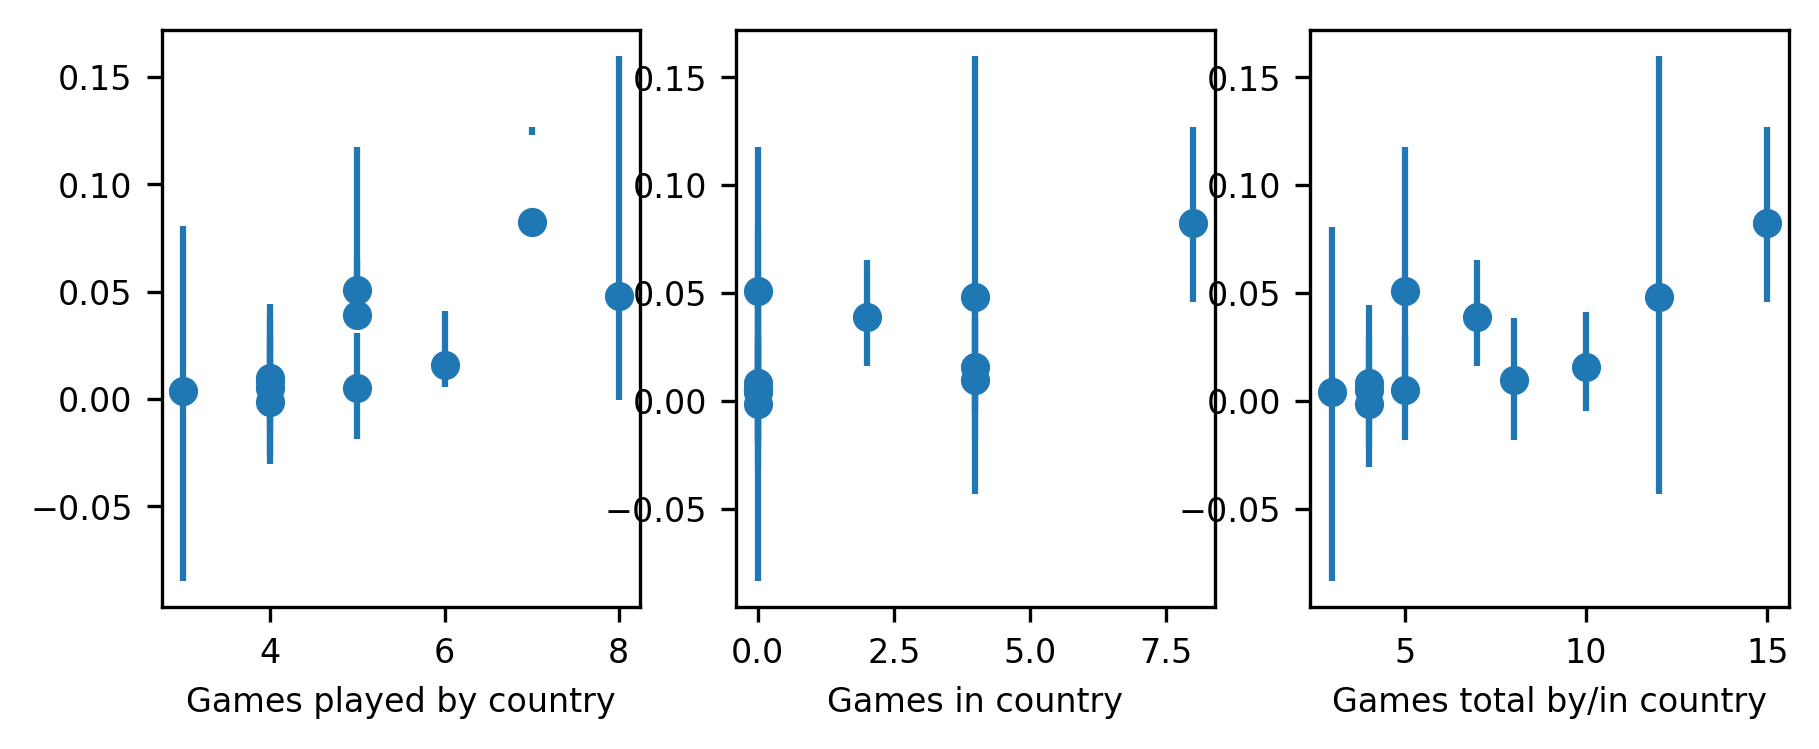

In [59]:
fig, axes = plt.subplots(1,3,figsize=(7,2.5))


axes[0].errorbar(
    n_games_by_team,
    mean,
    yerr=[m - p025, p975 - mean],
    ls="",
    marker="o"
)
axes[0].set_xlabel("Games played by country")

axes[1].errorbar(
    n_games_in_country,
    mean,
    yerr=[mean - p025, p975 - mean],
    ls="",
    marker="o"
)
axes[1].set_xlabel("Games in country")


axes[2].errorbar(
    np.array(n_games_in_country)+np.array(n_games_by_team),
    mean,
    yerr=[mean - p025, p975 - mean],
    ls="",
    marker="o"
)
axes[2].set_xlabel("Games total by/in country")

plt.show()

In [60]:
from sklearn.linear_model import LinearRegression


# Run model for each possibility
models_nGamesByTeam = []
models_nGamesInCountry = []
models_nGamesTotal = []

means = np.array([np.mean(ef,axis=-1) for ef in effect])

# Bootstrap
n_bootstrap = 10000
for i in range(n_bootstrap):
    sample = []
    for country in range(means.shape[0]):
        # Draw random sample
        sample.append(np.random.choice(means[country], size=1, replace=True)[0])
    sample = np.array(sample)
    models_nGamesByTeam.append(LinearRegression().fit(np.array(n_games_by_team).reshape(-1, 1), sample))
    models_nGamesInCountry.append(LinearRegression().fit(np.array(n_games_in_country).reshape(-1, 1), sample))
    models_nGamesTotal.append(LinearRegression().fit((np.array(n_games_in_country)+np.array(n_games_by_team)).reshape(-1, 1), sample))


/tmp/ipykernel_342628/1926455883.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  means = np.array([np.mean(ef,axis=-1) for ef in effect])


In [61]:
def plot(ax,GamesXCountry,models):
    
    x = np.arange(0,np.max(GamesXCountry)+1,0.1)
    # Get y values
    y = []
    for model in models:
        y.append(model.predict(x.reshape(-1,1)))
    y = np.array(y)

    # Compute mean and ci
    mean_mod = y.mean(axis=0)
    p025_mod = np.percentile(y, 2.5,axis=0)
    p975_mod = np.percentile(y,97.5,axis=0)

    # Plot error bars
    lines = ax.vlines(
        x=GamesXCountry,
        ymin=p025,
        ymax=p975,
        lw=2,
        zorder=9,
        color="#060434",
    )
    lines.set_capstyle("round")
    ax.scatter(
        x=GamesXCountry,
        y=mean,
        marker="o",
        s=10,
        zorder=10,
        c="white",
        edgecolor="#060434",
    )

    # Plot model fit
    ax.plot(x,mean_mod,color="#009988",lw=1)
    ax.fill_between(x,p025_mod,p975_mod,color="#009988",alpha=0.2)


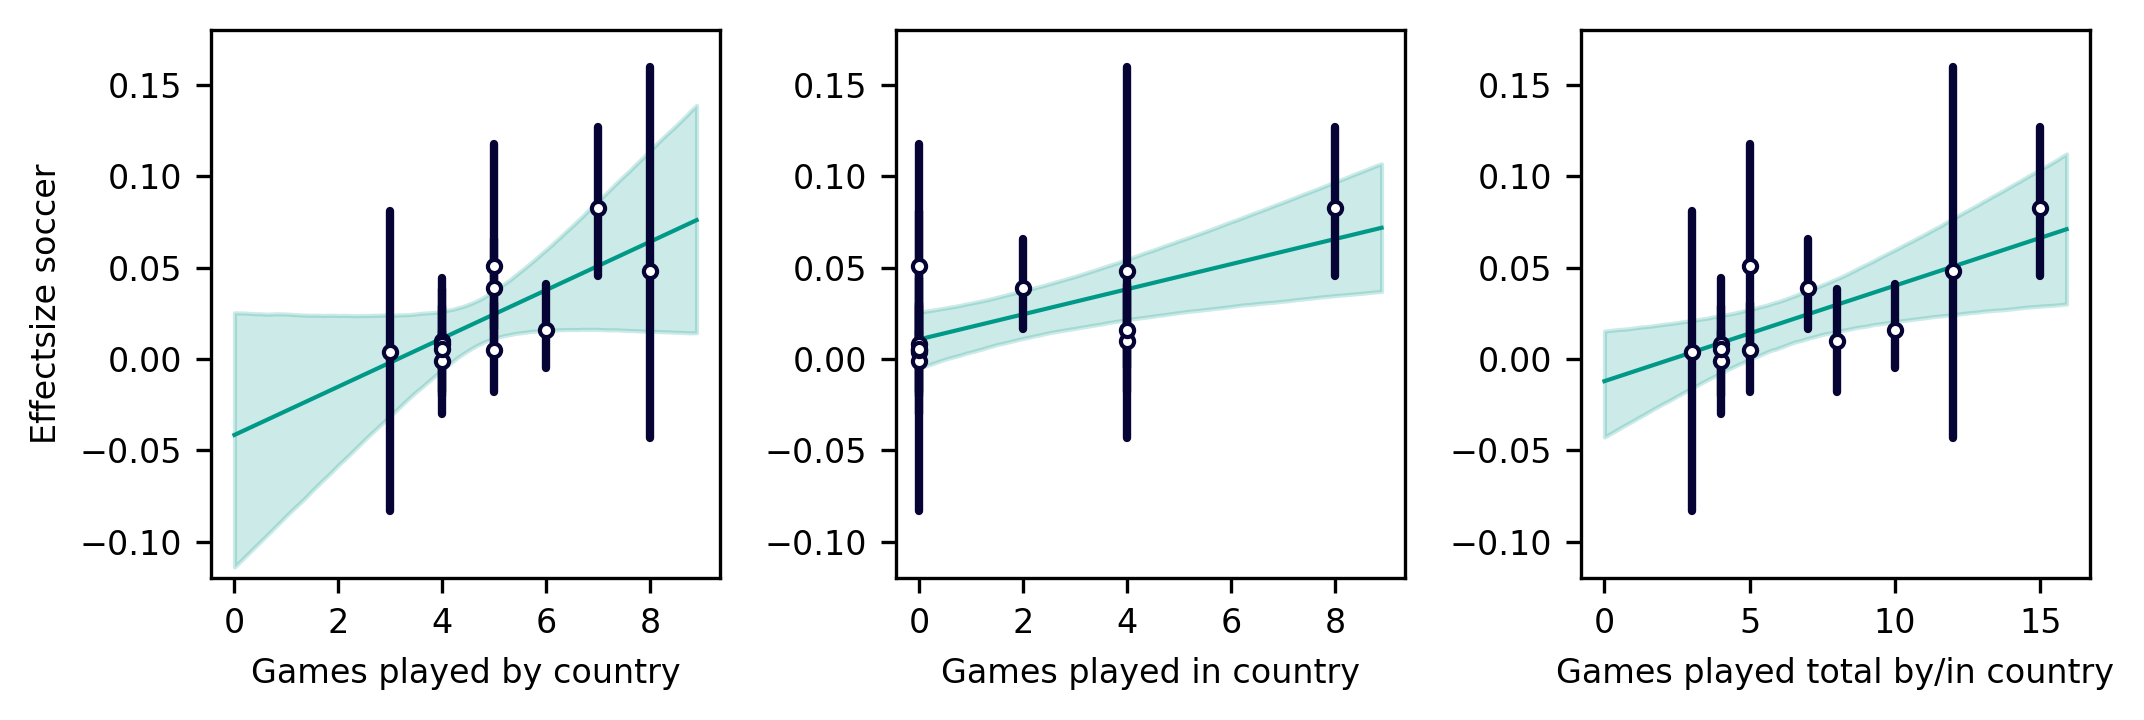

In [62]:
fig, axes = plt.subplots(1,3,figsize=(7,2.5))

plot(axes[0],n_games_by_team,models_nGamesByTeam)
axes[0].set_xlabel("Games played by country")


plot(axes[1],n_games_in_country,models_nGamesInCountry)
axes[1].set_xlabel("Games played in country")


plot(axes[2],np.array(n_games_in_country)+np.array(n_games_by_team),models_nGamesTotal)
axes[2].set_xlabel("Games played total by/in country")


plt.tight_layout()

for ax in axes:
    ax.set_ylim(-0.12,0.18)

axes[0].set_ylabel("Effectsize soccer")

fig.savefig(f"{fig_path}/effect_vs_nGames.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/effect_vs_nGames.png", **save_kwargs)

plt.show()

In [63]:
# Save data to plot in other figure
import pickle


pickle.dump(
    [np.array(n_games_in_country)+np.array(n_games_by_team),
    models_nGamesTotal,
    [mean,p025,p975]],
    open(f"{fig_path}/effect_vs_nGames.pkl","wb")
)